# Example Burgers' equation

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [1]:
import matplotlib.pyplot as plt

# General imports
import numpy as np
import torch

# DeePyMoD imports
from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.data.burgers import burgers_delta
from deepymod.model.constraint import LeastSquares
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.sparse_estimators import Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import Periodic, TrainTest, TrainTestPeriodic

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


# Dataset
Create all the argument we need to create a Burgers dataset:

In [2]:
# Making dataset
v = 0.1
A = 1.0

x = torch.linspace(-3, 4, 100)
t = torch.linspace(0.5, 5.0, 50)
load_kwargs = {"x": x, "t": t, "v": v, "A": A}
preprocess_kwargs = {"noise_level": 0.05}

Then we pass this function to the dataset class, which then adds noise to it, normalizes the coordinates and performs random subsampling to it.

In [3]:
dataset = Dataset(
    burgers_delta,
    load_kwargs=load_kwargs,
    preprocess_kwargs=preprocess_kwargs,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 500},
    device=device,
)

Dataset is using device:  cuda


Let's plot it to get an idea of the data. As we can see, $X$ has 2 dimensions, $\{x, t\}$, while $y$ has only one, $\{u\}$. Always explicity set the shape (i.e. $N\times 1$, not $N$) or you'll get errors. We also added 5% of noise.

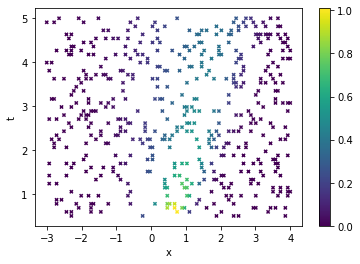

In [4]:
coords = dataset.get_coords().cpu()
data = dataset.get_data().cpu()
fig, ax = plt.subplots()
im = ax.scatter(coords[:,1], coords[:,0], c=data[:,0], marker="x", s=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)

plt.show()

We now also wish to split the data into a train and test split, specifically into loaders, which handle the logic of passing the samples to the model.

In [5]:
train_dataloader, test_dataloader = get_train_test_loader(
    dataset, train_test_split=0.8
)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [6]:
network = NN(2, [50, 50, 50,50], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [7]:
library = Library1D(poly_order=2, diff_order=3) 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [8]:
estimator = Threshold(0.1) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5) 

Configuration of the sparsity estimator 

In [9]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and send it to the GPU and select the optimizer 

In [10]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 


## Run DeepMoD 

We can now run DeepMoD using all the options we have set, the training and test loaders:
* The directory where the tensorboard file is written (log_dir)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [11]:
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    exp_ID="Test",
    write_iterations=25,
    max_iterations=100000,
    delta=1e-4,
    patience=200,
)

 11650  MSE: 2.47e-06  Reg: 4.33e-06  L1: 1.95e+00 Algorithm converged. Writing model to disk.


Sparsity masks provide the active and non-active terms in the PDE:

In [12]:
model.sparsity_masks

[tensor([False, False,  True, False, False,  True, False, False, False, False,
         False, False], device='cuda:0')]

estimatior_coeffs gives the magnitude of the active terms:

In [13]:
print(model.estimator_coeffs())

[array([[ 0.        ],
       [ 0.        ],
       [ 0.79008406],
       [ 0.        ],
       [ 0.        ],
       [-1.1257259 ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)]


So the final terms that remain are the $u_{xx}$ and $u u_{x}$ resulting in the following Burgers equation (in normalized coefficients: 
$u_t = 0.4 u_{xx} - u u_{x}$.